In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot, imsave
from ponyslayer import unicorn, transform

## Parameters Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.15 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

# Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (5, 5)

## Load Image

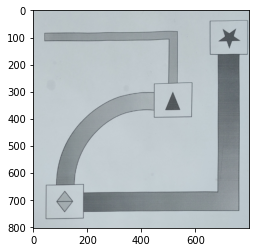

In [4]:
frame = cv2.imread("Picture3.jpg")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
original = frame.copy()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
imshow(frame)

## Unsharp Masking

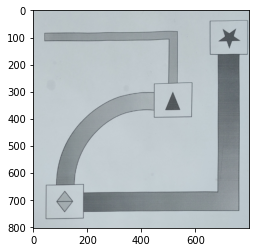

In [5]:
if UnsharpMaskBeforeFindMarker:
    blur = cv2.GaussianBlur(frame, BlurKernelSize, 0)
    frame = cv2.addWeighted(frame, 2, frame, -1, 0, frame) # Apply Unsharp Masking
    imshow(frame)
    cv2.imwrite("unsharp.jpg", frame)

## Enhance Marker Border

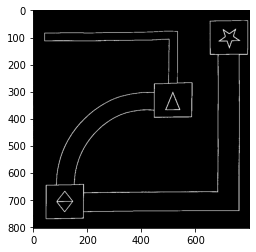

In [6]:
kernel = np.ones(BlurKernelSize,np.uint8)
# Find Marker borer by difference
dilation = cv2.dilate(frame,kernel,iterations = 1)
diff = cv2.absdiff(dilation, frame)

# Convert to binary
diff_bin = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
frame = cv2.inRange(diff_bin, 50, 255)
imsave(frame, "edge_thresh")

## Find Marker

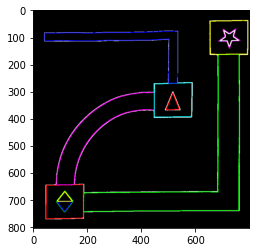

Match 87.45%
Match 86.77%
Match 87.51%


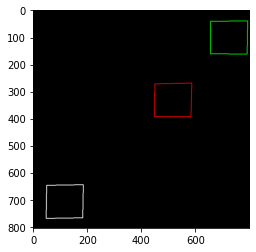

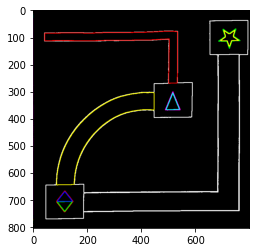

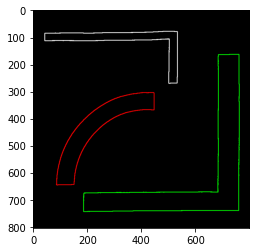

In [7]:
contours,hierarchy = cv2.findContours(frame, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

imdraws_color(contours,original, mode = 1, size = 2)

cp = unicorn.ContourProcessor()
cp.set_param(image_resolution, image_size, marker_size, marker_size_error, min_path_length, max_path_length, min_path_width, max_path_width)

cnts_marker, cnts_not_marker = cp.get_marker_contours(contours)
Markers = [unicorn.Marker(c) for c in cnts_marker] # Store as Unicorn.Marker object

imdraws_color(cnts_marker,original, mode = 1, size = 2)
imdraws_color(cnts_not_marker,original, mode = 1, size = 2)
## filter out contour that overlapped with marker (>50%)
objects_outside_marker = []
objects_inside_marker = []
canvas = np.zeros_like(gray, np.uint8)
marker_area = (image_resolution / image_size * marker_size)**2
for candidate in cnts_not_marker:
    overlapped = False
    mask_c = cv2.drawContours(canvas.copy(), cnts_marker, -1, 255, -1)
    mask_candidate = cv2.drawContours(canvas.copy(), [candidate], -1, 255, -1)
    overlapped_mask = cv2.bitwise_and(mask_candidate, mask_c)
    overlapped_area = np.sum(overlapped_mask == 255)
    outside_area = np.sum(mask_candidate == 255) - overlapped_area
    if overlapped_area > marker_area/2: overlapped = True
    if not overlapped:
        if outside_area == 0:
            objects_inside_marker.append(candidate)
        else:
            objects_outside_marker.append(candidate)

## filter for contour by first N most area
cnts_path = sorted(objects_outside_marker, key=cv2.contourArea)[-len(Markers):]
imdraws_color(cnts_path,original, mode = 1, size = 2)
## Path don't need approximation of contour
Paths = []
for c in cnts_path:
    c_mask = cv2.drawContours(canvas.copy(), [c], -1, 255, -1)
    contours,_ = cv2.findContours(c_mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    Paths.append(unicorn.Path(contours[0])) # Store as Unicorn.Path object

## Locate First Marker

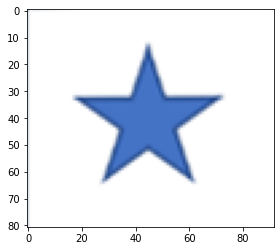

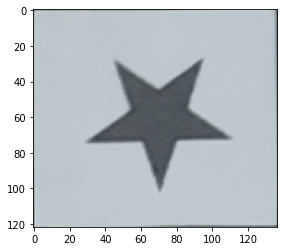

In [8]:
first_marker_src = cv2.imread("Start1.png")
imshow(first_marker_src)

###########################################

first_marker = Markers[2]
# imshow(transform.four_point_transform(original, cp.getPointArray(first_marker.contour)))
imshow(first_marker.getImage(original))

## Sort Marker & Path

6


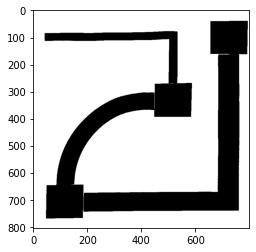

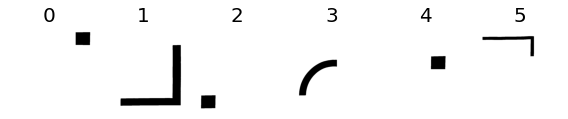

In [9]:
### Sort Marker & Path ###
present = first_marker
sorted_object = []
sorted_object.append(present)
n_object = len(Markers) + len(Paths)

while n_object != len(sorted_object):
    candidates = list(filter(lambda x: x not in sorted_object, Markers + Paths)) # Unsorted objects
    _isPath_next = present in Markers # Marker -> Path -> Marker -> Path -> Marker -> Path
    present = sorted(candidates, key=lambda o: cp.minDistance(present.contour, o.contour))[0]
    sorted_object.append(present)
print(len(sorted_object))
immasks([x.contour for x in sorted_object], frame)
visual = [immask(item.contour, frame) for item in sorted_object]
imshows(visual, [str(x) for x in range(len(visual))])

## Assign Start point on each Path

(724, 163)
(116, 644)
(505, 270)


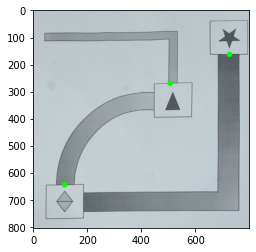

In [10]:
canvas = original.copy()
for i in range(int(len(sorted_object)/2)):
    marker = sorted_object[2*i]
    path = sorted_object[2*i+1]
    path_start_point = cp.nearestPoint(marker.center, path.contour)
    path.set_start(path_start_point)
    print(path.start)
    cv2.circle(canvas, path.start, 10, (0, 255, 0), -1)
imshow(canvas)

## Generate 2D Waypoints and Extract Gradient

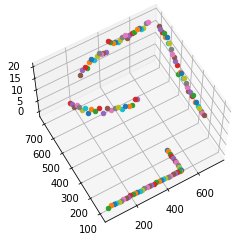

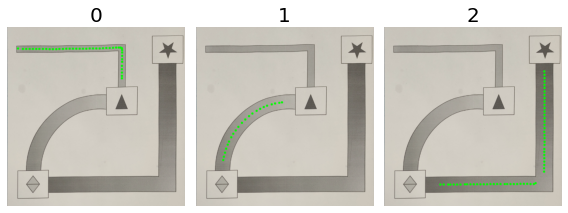

In [11]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
visual = []
for Path in Paths:
    duo_list, middle = Path.generate_trajectory2D_rev3(Markers, cp.marker_size_pixel, marker_size_error*2, step_size = 15)
    canvas = original.copy()
    for i in range(len(middle)): cv2.circle(canvas, middle[i], 5, (0, 255, 0), -1)
    visual.append(canvas)
    waypoints3D = Path.generate_trajectory3D(src=gray,
                                             min_height=min_height,
                                             max_height=max_height,
                                             gradient_crop_ratio=gradient_crop_ratio,
                                             min_intensity_range=min_intensity_range)
    
    
    for waypoint in waypoints3D: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
ax.view_init(azim=-120, elev=60)
plt.show()
imshows(visual, [str(i) for i in range(len(visual))])

## Generate 3D Waypoints

<IPython.core.display.Javascript object>


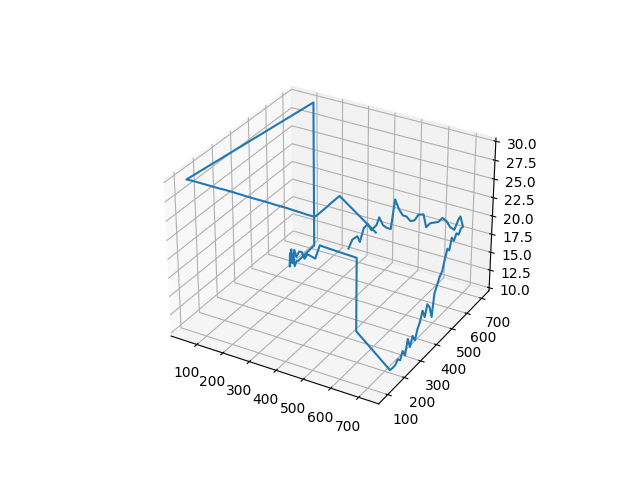

In [12]:
H = 30 # Height buffer
waypoints = [] # List of (x, y, z)
for i in range(len(Markers)):
    ### Marker ###
    (x, y) = sorted_object[2*i].center
    waypoints.append((x, y, H)) # Hold height
    if Paths[i].waypoints3D[0][2] == -1: z = H
    else: z = Paths[i].waypoints3D[0][2]
    waypoints.append((x, y, z)) # Adjust height
    H = z # update history
    ### Path ###
    for (x, y, z) in Paths[i].waypoints3D:
#         print(H)
        if z == -1: z = H # Hold height
        waypoints.append((x, y, z))
        H = z # update history
%matplotlib notebook
#%%

fig = plt.figure()
ax = fig.gca(projection='3d')
# for waypoint in waypoints: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
x = [waypoints[i][0] for i in range(len(waypoints))]
y = [waypoints[i][1] for i in range(len(waypoints))]
z = [waypoints[i][2] for i in range(len(waypoints))]
ax.plot(x, y, z)
plt.show()